# Machine learning applied to hyperspectral images <a id="top-notebook"></a>

**Members**:
* louis.guo
* raphael.ramelet
* ilan.guenet

**Table of content**:
* [Load data](#load-data)
* [Dimension reduction](#dimension-reduction)
* [Split data](#split-data)
* [Multiclass classification](#multiclass-classification)
    * [LinearSVC](#linear-svc)
    * [RandomForest](#random_forest)



Import python depedencies. Remember to run ```pip3 install -r requirements.txt``` before running the notebook

In [2]:
# !pip3 install -r requirements.txt

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
import pandas as pd
import seaborn as sn

%matplotlib inline

random_state = 2727

## Load data <a id="load-data"></a>
[Table of content](#top-notebook)

### Hyperspectral image

In [4]:
!ls data/

indianapines_gt.npy  indianapines.npy  salinas_gt.npy  salinas.npy


In [5]:
X_indiana = np.load("data/indianapines.npy").astype('float32')
X_indiana.shape, X_indiana.dtype, np.min(X_indiana), np.max(X_indiana)

((145, 145, 200), dtype('float32'), 955.0, 9604.0)

In [6]:
def plot_rgb(im, title):
    rgb_bands = np.array([30, 15, 2])
    im_rgb = im[:,:,rgb_bands]

    pmin, pmax = np.percentile(im_rgb, (1,99), axis=(0,1))
    
    for i in range(pmin.size):
        # Normalize
        im_rgb[:,:,i] = (im_rgb[:,:,i] - pmin[i]) / (pmax[i] - pmin[i])
        
    im_rgb[im_rgb<0] = 0
    im_rgb[im_rgb>1] = 1
    plt.axis("off")
    plt.title(title)
    plt.imshow(im_rgb)
    plt.plot()

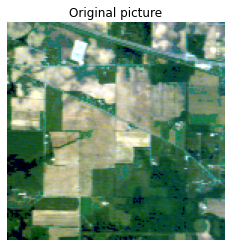

In [7]:
plot_rgb(X_indiana, "Original picture")

### Load labels

In [8]:
y_indiana = np.load("data/indianapines_gt.npy")
y_indiana.shape, y_indiana.dtype, np.min(y_indiana), np.max(y_indiana)

((145, 145), dtype('uint8'), 0, 16)

We can see there are 17 categories. Category 0 is considered as a non-category.

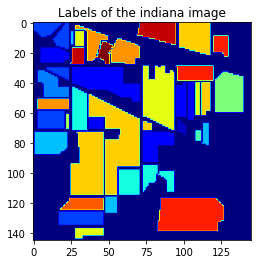

In [9]:
plt.imshow(y_indiana, cmap='jet')
plt.title("Labels of the indiana image")
plt.show()

### Dictionary label to category

In [10]:
label_to_category = { 0: "Other",
                      1: "Alfalfa",
                      2: "Corn-notill",
                      3: "Corn-mintill",
                      4: "Corn",
                      5: "Grass-pasture",
                      6: "Grass-trees",
                      7: "Grass-pasture-mowed",
                      8: "Hay-windrowed",
                      9: "Oats",
                     10: "Soybean-notill",
                     11: "Soybean-mintill",
                     12: "Soybean-clean",
                     13: "Wheat",
                     14: "Woods",
                     15: "Buildings-Grass-Trees-Drives",
                     16: "Stone-Steel-Towers"}
label_to_category   

{0: 'Other',
 1: 'Alfalfa',
 2: 'Corn-notill',
 3: 'Corn-mintill',
 4: 'Corn',
 5: 'Grass-pasture',
 6: 'Grass-trees',
 7: 'Grass-pasture-mowed',
 8: 'Hay-windrowed',
 9: 'Oats',
 10: 'Soybean-notill',
 11: 'Soybean-mintill',
 12: 'Soybean-clean',
 13: 'Wheat',
 14: 'Woods',
 15: 'Buildings-Grass-Trees-Drives',
 16: 'Stone-Steel-Towers'}

## Dimension reduction <a id="dimension-reduction"></a>

[Table of content](#top-notebook)

Machine learning is more efficient with lower dimensions. The hyperspectral image have 200 dimensions. That seems way too large for any machine learning algorithm. Thus, we are going to reduce the dimension of the problem using the **P**rincipal **C**omponents **A**nalysis (**PCA**) algorithm.

### Setup PCA

In [11]:
# The PCA requires a 2D matrix.
row, col, dim = X_indiana.shape
X_indiana = X_indiana.reshape((-1, dim))
X_indiana.shape

(21025, 200)

In [12]:
from sklearn.decomposition import PCA

pca = PCA(random_state=random_state)
pca

PCA(random_state=2727)

In [13]:
pca.fit(X_indiana)

PCA(random_state=2727)

### Analyse PCA

In [14]:
print(f"Number of components: {pca.n_components_} (equals to number of wavelength)")

Number of components: 200 (equals to number of wavelength)


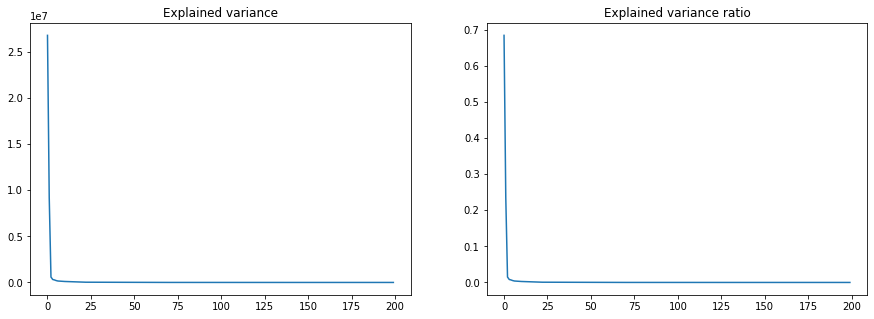

In [15]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(pca.explained_variance_)
plt.title("Explained variance")

plt.subplot(1, 2, 2)
plt.plot(pca.explained_variance_ratio_)
plt.title("Explained variance ratio")
plt.show()

In [16]:
print(f"The first component explains {np.floor(pca.explained_variance_ratio_[0] * 100)}% of the variance")
print(f"The second component explains {np.floor(pca.explained_variance_ratio_[1] * 100)}% of the variance")

The first component explains 68.0% of the variance
The second component explains 23.0% of the variance


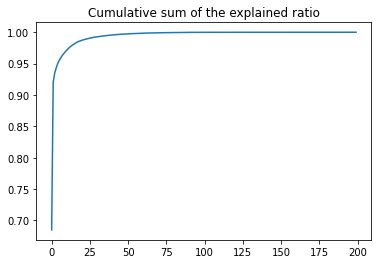

In [17]:
var_cumsum = pca.explained_variance_ratio_.cumsum()

plt.title("Cumulative sum of the explained ratio")
plt.plot(var_cumsum)
plt.show()

We can notice that the first principal components explains most of the variance. So we don't need to keep the last principal components. They usually hold the information of noise. As we want to reduce the dimensions, we are only going to use the first principal components to project data into a new space.

### Make decision

How many principal components are we going to use to project data? We want to project the data in a way that we preserved at least a percentage (threshold) of the variance (information). We can get this information for the cumulative sum of the expained variance. We pick as many principal components until their total explained variance is greater than the threshold.

In [18]:
threshold = 0.95 # 95%

# Number of selected principal components such as the cumulative sum of the explained 
# variance ratio of these principal components is at least greater than the threshold 
nb_pc = np.where(var_cumsum>threshold)[0][0] + 1
print('%d explains at least %1.2f%% of the variance'%(nb_pc, threshold * 100))

5 explains at least 95.00% of the variance


In [19]:
## We need to fit again to use the new params 
pca_params = {"n_components" : nb_pc}
pca = pca.set_params(**pca_params)
pca.fit(X_indiana)

PCA(n_components=5, random_state=2727)

### Projection

In [20]:
# Projection of the data through the new basis from the PCA
Xproj = pca.transform(X_indiana).reshape((row, col, nb_pc))
Xproj.shape

(145, 145, 5)

The hyperspectral image is projected from 200 dimensions to the number of PC dimensions (5 if 95% is the threshold). The dimension are well reduced.

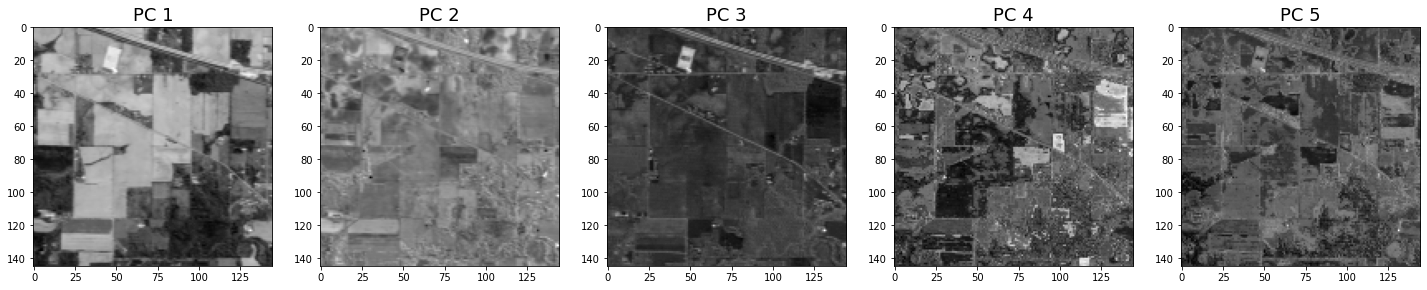

In [21]:
plt.figure(figsize=(30,15))
for i in range(nb_pc):
    plt.subplot(int(nb_pc / 6) + 1,6,i+1)
    plt.title('PC %d'%(i+1),fontsize=18)
    plt.imshow(Xproj[:,:,i],cmap='gray')
plt.show()

In [22]:
Xproj_back = pca.inverse_transform(Xproj) 

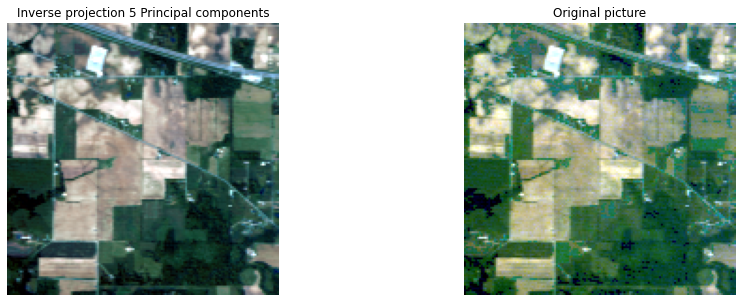

In [23]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plot_rgb(Xproj_back, "Inverse projection " + str(nb_pc) + " Principal components")
plt.subplot(1,2,2)
plot_rgb(X_indiana.reshape(row,col,dim), "Original picture")

### Extra information

#### Mean Square Error (MSE)

In [24]:
def MSE(im1,im2):
    if im1.ndim > 2:
        im1 = im1.reshape((-1,im1.shape[2]))
    if im2.ndim > 2:
        im2 = im2.reshape((-1,im2.shape[2]))
    mse = ((im1-im2)**2).sum(axis=1).mean()
    return mse

In [25]:
MSE(Xproj_back, X_indiana)

1941170.2

In [26]:
nb_pc_range = np.unique(np.round(np.geomspace(1, 190, num=20))).astype(int)
nb_pc_range

array([  1,   2,   3,   4,   5,   7,   9,  12,  16,  21,  27,  36,  48,
        63,  83, 109, 144, 190])

In [27]:
mse_seq = []
for nb_pc_curr in nb_pc_range:
    pca_mse = PCA(n_components = nb_pc_curr, random_state = random_state)
    testproj = pca_mse.fit_transform(X_indiana)
    testproj_back = pca_mse.inverse_transform(testproj).reshape((row,col,dim))
    mse_seq.append(MSE(testproj_back, X_indiana))

mse_seq = np.array(mse_seq)

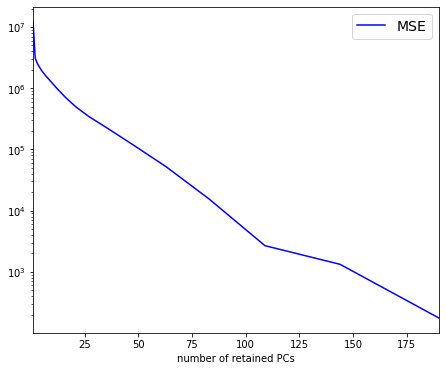

In [28]:
plt.figure(figsize=(16,6))
plt.subplot(121)
plt.plot(nb_pc_range, mse_seq, 'b', label='MSE')
plt.xlim(nb_pc_range[0], nb_pc_range[-1])
plt.xlabel('number of retained PCs')
plt.yscale('log')
plt.legend(loc='best', fontsize=14)
plt.show()

## Split data<a id="split-data"></a>

[Table of content](#top-notebook)

In [29]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_indiana, 
                                                    y_indiana.flatten(), 
                                                    test_size=0.15,
                                                    random_state=random_state)
X_train.shape, X_test.shape

((17871, 200), (3154, 200))

## Multiclass classification<a id="multiclass-classification"></a>

[Table of content](#top-notebook)

Documentation:
* <a href="https://scikit-learn.org/stable/modules/multiclass.html">link</a>

### LinearSVC (One Versus All)<a id="linear-svc"></a>

In [30]:
from sklearn.svm import LinearSVC

Pipeline with PCA, LinearSVC

1. Training:
    1. PCA.fit(X_train)
    2. Xproj = pca.transform(X_train)
    3. LinearSVC.fit(Xproj, y_train)
2. Test
    1. Xproj_test = pca.tranform(X_test)
    2. LinearSVC.predict(X_proj_test, y_test)

In [31]:
# Get the number of components for each threshold
thresholds = [0.90, 0.95, 0.99]


pca = PCA(random_state=random_state)
pca.fit(X_train)
param_n_components = []
for threshold in thresholds:
    var_cumsum = pca.explained_variance_ratio_.cumsum()
    param_n_components.append(np.where(var_cumsum>threshold)[0][0] + 1)
    
param_n_components

[2, 5, 25]

In [32]:
max_iter_range = [(i + 1) * 1000 for i in range(4)]
max_iter_range

[1000, 2000, 3000, 4000]

In [95]:
from sklearn.model_selection import GridSearchCV
# / Positional argument before
# * Must name the parameter
def grid_search(pipe, X, y, grid_params, /, *, n_jobs=-1, verbose=4):
    # Create the gridsearch
    # Cross validation gridsearch
    gs = GridSearchCV(pipe, grid_params, n_jobs=-1, verbose=4)
    print("---- Start search ----")
    gs.fit(X, y)
    print("---- Search finished ----")
    print("Best parameter (CV score=%0.3f): " % gs.best_score_)
    print(gs.best_params_)
    return gs.best_params_

In [34]:
from sklearn.pipeline import Pipeline

# Create pipeline
pca = PCA(random_state=random_state)
linear_svc = LinearSVC(multi_class='ovr', random_state=random_state)

pipe = Pipeline(steps=[('pca', pca), ('linearsvc', linear_svc)])
pipe

Pipeline(steps=[('pca', PCA(random_state=2727)),
                ('linearsvc', LinearSVC(random_state=2727))])

In [113]:
# Create the grid search
# Key = step name from pipeline + __ + hyperparameter, value = tuple of possible values
grid_params = {
    'pca__n_components': param_n_components,
    'linearsvc__max_iter': max_iter_range,
}

best_params = grid_search(pipe, X_train, y_train, grid_params)

---- Start searching ----
Fitting 5 folds for each of 3 candidates, totalling 15 fits
---- Searching finished ----
Best parameter (CV score=0.280): 
{'linearsvc__max_iter': 1, 'pca__n_components': 25}


/home/li0nmo0se/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


In [36]:
def evaluate_clf(clf, X_train, y_train, X_test, y_test):
    clf.fit(X_train, y_train)
    return clf.score(X_test, y_test)

In [116]:
# Create pipeline from the best parameters
# linear_svc = LinearSVC(multi_class='ovr', random_state=random_state, max_iter=best_params['linearsvc__max_iter'])
# pca = PCA(random_state=random_state, n_components=best_params['pca__n_components'])
pca = PCA(random_state=random_state, n_components=5)
linear_svc = LinearSVC(multi_class='ovr', random_state=random_state, max_iter=3000)
pipe = Pipeline(steps=[('pca', pca), ('linearsvc', linear_svc)])

evaluate_clf(pipe, X_train, y_train, X_test, y_test)

/home/li0nmo0se/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


0.4254914394419784

In [105]:
from sklearn.metrics import confusion_matrix, classification_report, f1_score

def my_classification_report(clf, X, y, classes, clf_name=None):
    y_pred = clf.predict(X)
    
    # Confusion matrix
    conf_matrix = confusion_matrix(y, y_pred)
    df_cm = pd.DataFrame(conf_matrix, classes, classes)
    plt.figure(figsize=(10,10))
    sn.set(font_scale=1.4) # for label size
    ax = sn.heatmap(df_cm, cmap='Oranges', annot=True, fmt='g', annot_kws={"size": 11}) # font size
    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')
    if clf_name:
        plt.title("Confusion matrix with " + clf_name + " classifier.")
    else:
        plt.tile("Confusion matrix")
        
    ax.plot([1, 0], [0, 1], linewidth=0.2, color='black', transform=ax.transAxes)
    plt.show()
    
    # Classification report
    print(classification_report(y, y_pred, target_names=classes))

    return f1_score(y, y_pred, average='weighted')

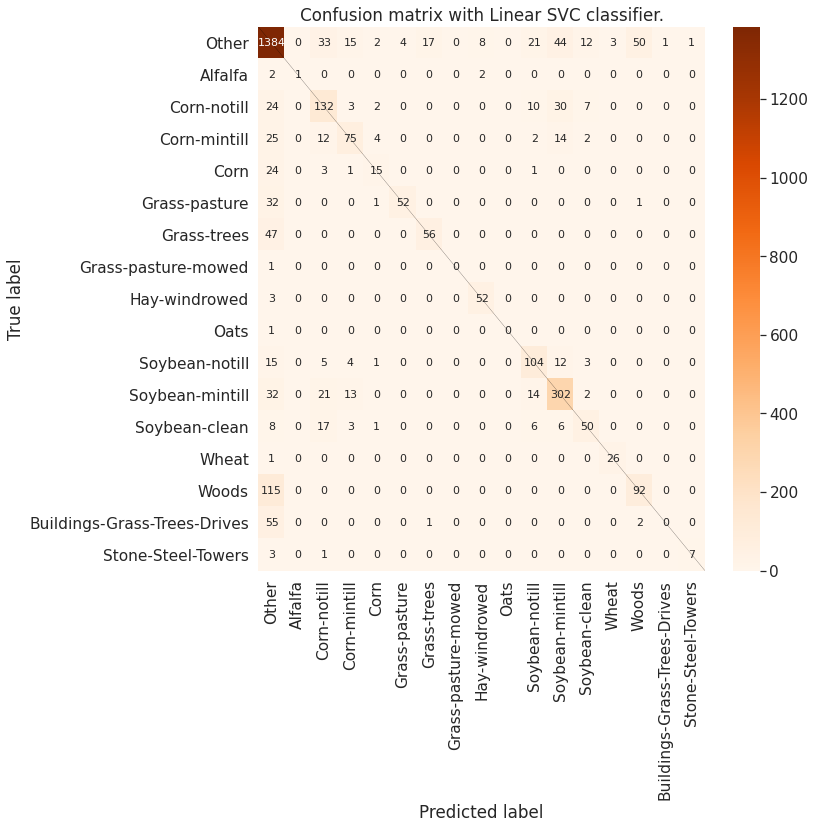

                              precision    recall  f1-score   support

                       Other       0.78      0.87      0.82      1595
                     Alfalfa       1.00      0.20      0.33         5
                 Corn-notill       0.59      0.63      0.61       208
                Corn-mintill       0.66      0.56      0.60       134
                        Corn       0.58      0.34      0.43        44
               Grass-pasture       0.93      0.60      0.73        86
                 Grass-trees       0.76      0.54      0.63       103
         Grass-pasture-mowed       0.00      0.00      0.00         1
               Hay-windrowed       0.84      0.95      0.89        55
                        Oats       0.00      0.00      0.00         1
              Soybean-notill       0.66      0.72      0.69       144
             Soybean-mintill       0.74      0.79      0.76       384
               Soybean-clean       0.66      0.55      0.60        91
                   

/home/li0nmo0se/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/li0nmo0se/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/li0nmo0se/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [97]:
my_classification_report(pipe, X_test, y_test, label_to_category.values(), clf_name="Linear SVC")

### RandomForest (Inherently multiclass)<a id="random_forest"></a>

In [51]:
from sklearn.ensemble import RandomForestClassifier

In [131]:
pca = PCA(random_state=random_state)
random_forest_clf = RandomForestClassifier()
pipe = Pipeline(steps=[('pca', pca), ('random_forest', random_forest_clf)])

grid_params = {
    'pca__n_components': param_n_components,
    'random_forest__n_estimators': [100, 500, 1000, 2000],
}
print(pipe)
print(grid_params)

Pipeline(steps=[('pca', PCA(n_components=5, random_state=2727)),
                ('random_forest', RandomForestClassifier())])
{'pca__n_components': [2, 5, 25], 'random_forest__n_estimators': [100, 500, 1000]}


In [132]:
%%time
best_params = grid_search(pipe, X_train, y_train, grid_params)

---- Start searching ----
Fitting 5 folds for each of 9 candidates, totalling 45 fits


/home/li0nmo0se/.local/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


---- Searching finished ----
Best parameter (CV score=0.776): 
{'pca__n_components': 25, 'random_forest__n_estimators': 1000}
CPU times: user 1min 27s, sys: 1.59 s, total: 1min 28s
Wall time: 5min 4s


In [133]:
pca = PCA(random_state=random_state, n_components=best_params['pca__n_components'])
random_forest_clf = RandomForestClassifier(n_estimators=best_params['random_forest__n_estimators'])

pipe = Pipeline(steps=[('pca', pca), ('random_forest', random_forest_clf)])
evaluate_clf(pipe, X_train, y_train, X_test, y_test)

0.7834495878249842

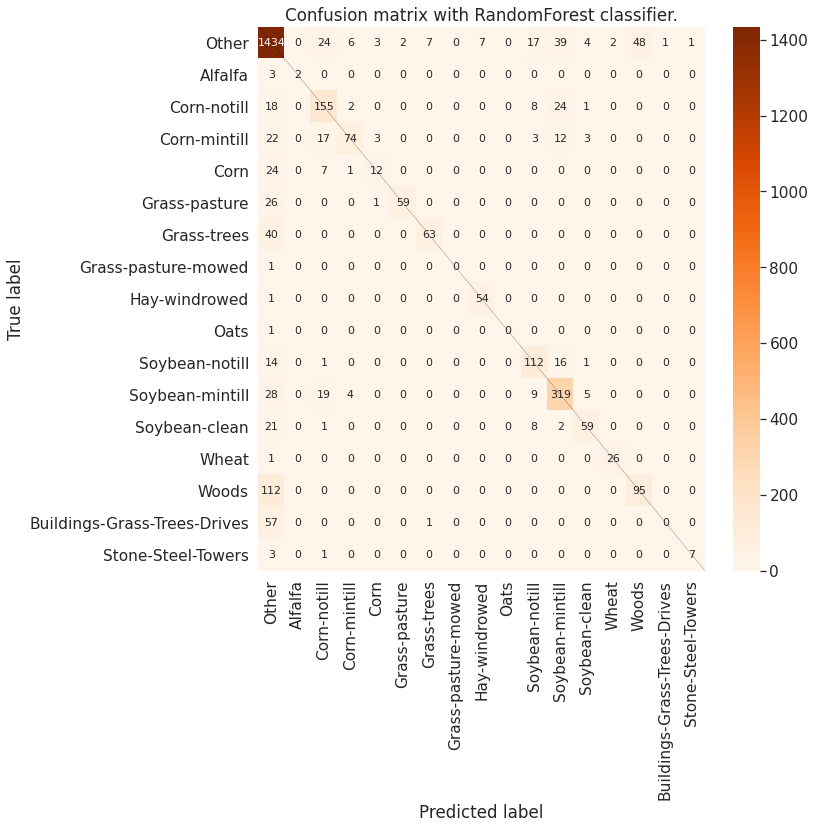

                              precision    recall  f1-score   support

                       Other       0.79      0.90      0.84      1595
                     Alfalfa       1.00      0.40      0.57         5
                 Corn-notill       0.69      0.75      0.72       208
                Corn-mintill       0.85      0.55      0.67       134
                        Corn       0.63      0.27      0.38        44
               Grass-pasture       0.97      0.69      0.80        86
                 Grass-trees       0.89      0.61      0.72       103
         Grass-pasture-mowed       0.00      0.00      0.00         1
               Hay-windrowed       0.89      0.98      0.93        55
                        Oats       0.00      0.00      0.00         1
              Soybean-notill       0.71      0.78      0.74       144
             Soybean-mintill       0.77      0.83      0.80       384
               Soybean-clean       0.81      0.65      0.72        91
                   

/home/li0nmo0se/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/li0nmo0se/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/li0nmo0se/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [134]:
my_classification_report(pipe, X_test, y_test, label_to_category.values(), "RandomForest")

In [44]:
np.array(np.where(y_train != 0))

array([[    2,     5,     6, ..., 17863, 17864, 17865]])

In [102]:
X_train_bis = X_train[np.where(y_train!=0)[0]].copy()
y_train_bis = y_train[np.where(y_train!=0)[0]].copy()
X_test_bis = X_test[np.where(y_test!=0)[0]].copy()
y_test_bis = y_test[np.where(y_test!=0)[0]].copy()
X_train_bis.shape, y_train_bis.shape, X_test_bis.shape, y_test_bis.shape, np.unique(y_train_bis)

((8690, 200),
 (8690,),
 (1559, 200),
 (1559,),
 array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16],
       dtype=uint8))

In [103]:
"""
{'pca__n_components': 25, 'random_forest__n_estimators': 1000}
"""

pca = PCA(random_state=random_state, n_components=25)
random_forest_clf = RandomForestClassifier(n_estimators=1000)

pipe_random_forest = Pipeline(steps=[('pca', pca), ('random_forest', random_forest_clf)])
evaluate_clf(pipe_random_forest, X_train_bis, y_train_bis, X_test_bis, y_test_bis)

0.8383579217447081

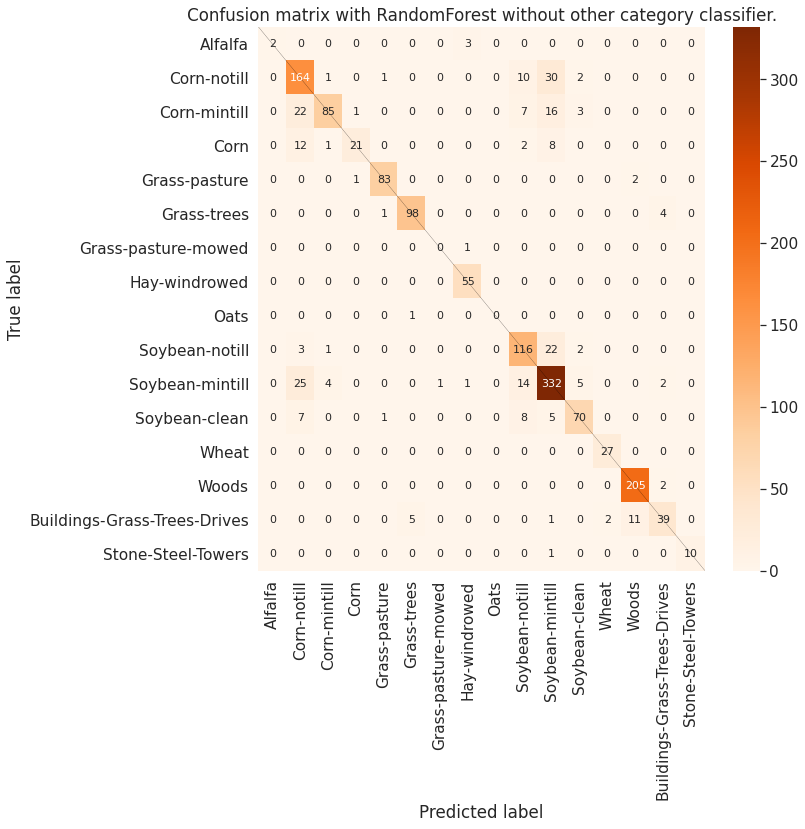

                              precision    recall  f1-score   support

                     Alfalfa       1.00      0.40      0.57         5
                 Corn-notill       0.70      0.79      0.74       208
                Corn-mintill       0.92      0.63      0.75       134
                        Corn       0.91      0.48      0.63        44
               Grass-pasture       0.97      0.97      0.97        86
                 Grass-trees       0.94      0.95      0.95       103
         Grass-pasture-mowed       0.00      0.00      0.00         1
               Hay-windrowed       0.92      1.00      0.96        55
                        Oats       0.00      0.00      0.00         1
              Soybean-notill       0.74      0.81      0.77       144
             Soybean-mintill       0.80      0.86      0.83       384
               Soybean-clean       0.85      0.77      0.81        91
                       Wheat       0.93      1.00      0.96        27
                   

/home/li0nmo0se/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/li0nmo0se/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/li0nmo0se/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.8352252682298391

In [106]:
my_classification_report(pipe_random_forest, X_test_bis, y_test_bis, list(label_to_category.values())[1:], "RandomForest without other category")

In [107]:
y_pred = pipe_random_forest.predict(X_test_bis)
print(f1_score(y_test_bis, y_pred, average='macro'))
print(f1_score(y_test_bis, y_pred, average='weighted'))

0.7248781182036148
0.8352252682298391


In [108]:
y_train_bin = np.where(y_train==0, 0, 1).copy()
y_test_bin = np.where(y_test==0, 0, 1).copy()
X_train.shape, y_train_bin.shape, np.unique(y_train_bin)

((17871, 200), (17871,), array([0, 1]))

In [ ]:
pca = PCA(random_state=random_state)
random_forest_clf = RandomForestClassifier()
pipe_bin = Pipeline(steps=[('pca', pca), ('random_forest', random_forest_clf)])

grid_params = {
    'pca__n_components': param_n_components,
    'random_forest__n_estimators': [100, 500, 1000, 2000],
}

best_param = grid_search(pipe_bin, X_train, y_train_bin, grid_params)

In [109]:
#pca = PCA(random_state=random_state, n_components=best_params['pca__n_components'])
#random_forest_clf = RandomForestClassifier(n_estimators=best_params['random_forest__n_estimators'])

pca = PCA(random_state=random_state, n_components=25)
random_forest_clf = RandomForestClassifier(n_estimators=3000)


pipe_bin = Pipeline(steps=[('pca', pca), ('random_forest', random_forest_clf)])
evaluate_clf(pipe_bin, X_train, y_train_bin, X_test, y_test_bin)

0.8303741280913126

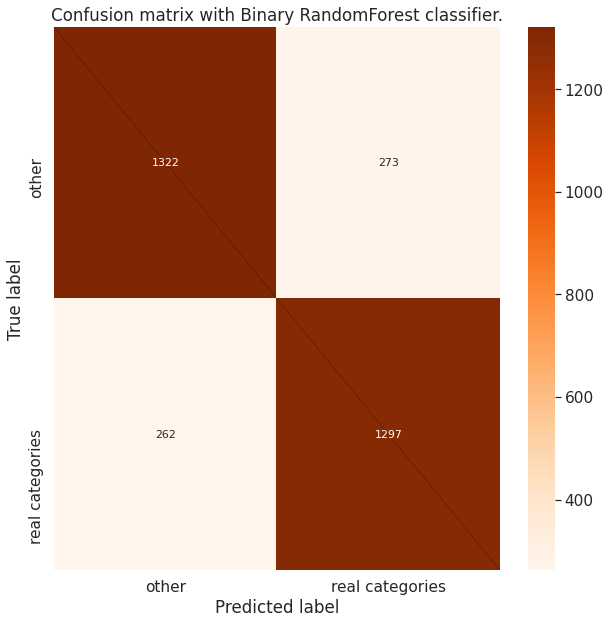

                 precision    recall  f1-score   support

          other       0.83      0.83      0.83      1595
real categories       0.83      0.83      0.83      1559

       accuracy                           0.83      3154
      macro avg       0.83      0.83      0.83      3154
   weighted avg       0.83      0.83      0.83      3154



0.8303788176145888

In [110]:
my_classification_report(pipe_bin, X_test, y_test_bin, ["other", "real categories"], "Binary RandomForest")

In [130]:
res_bin = pipe_bin.predict(X_test)
res = []
for i in range(len(res_bin)):
    if res_bin[i] == 0:
        res.append(0)
    else:
        res.append(pipe_random_forest.predict(X_test[np.newaxis, i])[0])
res = np.array(res, dtype=np.uint8)

In [131]:
print(f1_score(y_test, res, average='macro'))
print(f1_score(y_test, res, average='weighted'))

0.6022091203848757
0.7579419413822711


In [167]:
X_train_fix = np.empty((X_train_bis.shape[0] + 1, X_train_bis.shape[1]))
X_train_fix[:X_train_bis.shape[0], :] = X_train_bis
X_train_fix[-1, :] = np.zeros(X_train_bis.shape[1])
X_train_fix.shape

(8691, 200)

In [172]:
y_train_fix = np.append(y_train_bis, 0)
y_train_fix, np.unique(y_train_fix)

(array([15,  3,  6, ...,  2,  6,  0]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16]))

In [175]:
pca = PCA(random_state=random_state, n_components=25)
random_forest_clf = RandomForestClassifier(n_estimators=1000, warm_start=True)

pipe_random_forest = Pipeline(steps=[('pca', pca), ('random_forest', random_forest_clf)])

pipe_random_forest.fit(X_train_fix, y_train_fix) # Without category `other`

random_forest_clf.n_estimators += 1000

pipe_random_forest.fit(X_train, y_train) # With category `other`



Pipeline(steps=[('pca', PCA(n_components=25, random_state=2727)),
                ('random_forest',
                 RandomForestClassifier(n_estimators=2000, warm_start=True))])

In [177]:
y_pred = pipe_random_forest.predict(X_test)
print(f1_score(y_test, y_pred, average='macro'))
print(f1_score(y_test, y_pred, average='weighted'))
pipe_random_forest.score(X_test, y_test)

0.5973827712034693
0.7671898429571684


0.7793278376664553